# **(Manual Code) Ekstraksi Kata Kunci Dengan Text Rank**

Rumus TextRank:

$$ W_i = (1 - d) + d \cdot \sum_{j \in In(i)} \frac{w_{ij}}{\sum_{k \in Out(j)} w_{jk}} \cdot W_j $$

Penjelasan unsur-unsur dalam rumus tersebut:

- $(W_i)$: Skor TextRank untuk kata $(i)$.
- $(d)$: Faktor redaman (damping factor), seringkali bernilai sekitar 0.85.
- $(In(i))$: Himpunan kata-kata yang memiliki hubungan (edge) masuk ke kata $(i)$.
- $(Out(j))$: Himpunan kata-kata yang memiliki hubungan keluar dari kata $(j)$.
- $(w_{ij})$: Bobot hubungan antara kata $(i)$ dan $(j)$.

Rumus secara rinci:

$$ W_i = (1 - d) + d \cdot \sum_{j \in In(i)} \frac{w_{ij}}{\sum_{k \in Out(j)} w_{jk}} \cdot W_j $$

Penjelasan langkah-langkah rumus:

1. $(1 - d)$: Bagian dari rumus yang menyatakan kontribusi dampak faktor redaman.
2. $(\sum_{j \in In(i)})$: Penjumlahan atas kata-kata yang memiliki hubungan masuk ke kata $(i)$.
3. $(\frac{w_{ij}}{\sum_{k \in Out(j)} w_{jk}})$: Bagian yang menghitung kontribusi dari setiap kata yang memiliki hubungan keluar dari kata $(j)$. Fungsi ini memperhitungkan bobot relatif dari setiap hubungan keluar dari kata $(j)$.
4. $(W_j)$: Skor TextRank dari kata $(j)$. Skor ini dihitung pada iterasi sebelumnya dan digunakan untuk menghitung skor baru untuk kata $(i)$.

Dengan mengulangi rumus ini melalui beberapa iterasi, nilai skor TextRank untuk setiap kata akan konvergen ke nilai yang mencerminkan tingkat kepentingan kata-kata dalam teks. Pada akhirnya, kata-kata dengan skor TextRank tertinggi dianggap sebagai kata kunci atau kata-kata yang paling penting dalam teks tersebut.

## Perhitungan Manual (Spreadsheet)

[Text Rank Perhitungan Manual SpreadSheet](https://docs.google.com/spreadsheets/d/11xWaWDVXsRpCZzhUfdhRvgEYLeSVN3pg4R_ceTi6E0Y/edit?usp=sharing)

## Import Library

In [59]:
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from IPython.display import display
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import numpy as np
import nltk
import re

nltk.download('stopwords')
nltk.download('punkt')
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Fungsi Plot Graph

In [3]:
def plot_graph(G, figsize=(35, 30), node_size=700, node_color='skyblue'):
  # Menggambar graf dengan canvas yang diperbesar
  pos = nx.spring_layout(G)  # Menentukan posisi simpul
  labels = nx.get_edge_attributes(G, 'weight')

  # Menentukan ukuran canvas
  plt.figure(figsize=figsize)

  # Menggambar graf dengan ukuran canvas yang diperbesar
  nx.draw(G, pos, with_labels=True, node_size=node_size, node_color=node_color)
  nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='red')
  plt.show()

## Fungsi Membuat Graph dengan Co-occurence Matriks

In [97]:
def graph_co_occurrence(x, show_matrics=False):
  vectorizer = CountVectorizer()
  tfidf_matrics = vectorizer.fit_transform(x)
  co_occurrence_matrix = tfidf_matrics.T.dot(tfidf_matrics).toarray()
  df_co_occurence = pd.DataFrame(co_occurrence_matrix, columns=vectorizer.get_feature_names_out())
  df_co_occurence.insert(0, 'Word', vectorizer.get_feature_names_out())

  if show_matrics:
    print("Tabel Co-occurence Matrics: ")
    display(df_co_occurence)
    print()

  # Membuat graf berbobot menggunakan NetworkX
  G = nx.DiGraph()
  num_words = co_occurrence_matrix.shape[0]

  # Menambahkan edge ke graf berdasarkan matriks co-occurrence
  for i in range(num_words):
    for j in range(i + 1, num_words):
      weight = co_occurrence_matrix[i, j]
      if weight > 0:
        G.add_edge(vectorizer.get_feature_names_out()[i], vectorizer.get_feature_names_out()[j], weight=weight)
  return G

## Fungsi Text Rank Manual

In [67]:
def text_rank(graph, damping_factor=0.85, max_iter=100, tol=1e-4):
  # Inisialisasi nilai TextRank untuk setiap node
  initial_value = 1 / graph.number_of_nodes()
  ranks = {node: initial_value for node in graph.nodes()}

  print(f"Inisialisasi Score Awal : {ranks}")
  print(f"Edges : {graph.edges()}")
  print()

  for i in range(max_iter):
    new_ranks = {}
    print(f"========== Iterasi Ke - {i} ==========")

    for node in graph.nodes():
      rank_sum = 0
      operasi = ''

      # Menampilkan informasi out_sum dan win untuk setiap node dan neighbor
      out_sums_info = {}
      win = graph.in_degree(node, weight="weight")

      for neighbor in graph.predecessors(node):
        edge_weight = graph[neighbor][node]["weight"]
        out_sum = sum(graph[neighbor][out_neighbor]["weight"] for out_neighbor in graph.successors(neighbor))
        rank_sum += (edge_weight / out_sum) * ranks[neighbor]
        operasi += f"({edge_weight}/{out_sum}) * {ranks[neighbor]} + "

        # Menambah informasi out_sum untuk setiap neighbor
        out_sums_info[neighbor] = {out_neighbor: graph[neighbor][out_neighbor]["weight"] for out_neighbor in graph.successors(neighbor)}

      # Jika operasi kosong, atur nilai operasi menjadi 0
      operasi = operasi[:-3] if operasi else '0'

      new_rank = (1 - damping_factor) + damping_factor * rank_sum
      new_ranks[node] = new_rank

      # Menampilkan informasi out_sum dan win pada setiap iterasi
      print(f"Win({node}): {win}")
      print(f"Out_sums_info({node}): {out_sums_info}")
      print(f"W({node}) = (1 - {damping_factor}) + {damping_factor} * ({operasi}) = {new_rank}")
      print()

    # Periksa konvergensi
    convergence = all(abs(new_ranks[node] - ranks[node]) < tol for node in graph.nodes())
    ranks = new_ranks
    print(f"New Score : {new_ranks}")
    print()

    if convergence:
      print(f"Konvergensi tercapai pada iterasi ke-{i}")
      break

  return ranks

## Fungsi Ekstrak Kata Kunci Teratas

In [94]:
def extract_top_words(x, w=3, show_matrics=False, show_scores=False, index=None):
    full_text = ' '.join(word for word in x)

    G = graph_co_occurrence(x, show_matrics)

    # Menghitung nilai dari PageRank (TextRank)
    scores = text_rank(G)

    # Dictionary untuk menyimpan skor tertinggi setiap kata
    ranked_words_dict = {}

    for word in ' '.join(x).split():
        current_score = scores.get(word, 0)
        if word not in ranked_words_dict or current_score > ranked_words_dict[word]:
            ranked_words_dict[word] = current_score

    # Mengurutkan kata-kata berdasarkan skor tertinggi
    ranked_words = sorted(((score, word) for word, score in ranked_words_dict.items()), key=lambda x: (x[0], x[1]), reverse=True)

    # Memilih sejumlah w kata tertinggi
    selected_words = [word for _, word in ranked_words[:w]] if w is not None else None

    # Menggabungkan kata-kata menjadi satu string terpisah dengan koma
    keywords = ', '.join(selected_words) if selected_words else ''

    if show_scores:
      print(f'Dokumen ke {index} : {full_text}')
      print(f'{w} Kata Kunci : {keywords}')
      print("TextRank Scores:")
      for score, word in ranked_words:
          print(f"Skor: {score}, Kata: {word}")

    return (G, selected_words)

## Uji Coba dengan data

In [98]:
text = ['saya makan nasi']
G, keywords = extract_top_words(text, show_matrics=True)

Tabel Co-occurence Matrics: 


,Word,makan,nasi,saya
0,makan,1,1,1
1,nasi,1,1,1
2,saya,1,1,1



Inisialisasi Score Awal : {'makan': 0.3333333333333333, 'nasi': 0.3333333333333333, 'saya': 0.3333333333333333}
Edges : [('makan', 'nasi'), ('makan', 'saya'), ('nasi', 'saya')]

========== Iterasi Ke - 0 ==========
Win(makan): 0
Out_sums_info(makan): {}
W(makan) = (1 - 0.85) + 0.85 * (0) = 0.15000000000000002

Win(nasi): 1
Out_sums_info(nasi): {'makan': {'nasi': 1, 'saya': 1}}
W(nasi) = (1 - 0.85) + 0.85 * ((1/2) * 0.3333333333333333) = 0.2916666666666667

Win(saya): 2
Out_sums_info(saya): {'makan': {'nasi': 1, 'saya': 1}, 'nasi': {'saya': 1}}
W(saya) = (1 - 0.85) + 0.85 * ((1/2) * 0.3333333333333333 + (1/1) * 0.3333333333333333) = 0.575

New Score : {'makan': 0.15000000000000002, 'nasi': 0.2916666666666667, 'saya': 0.575}

========== Iterasi Ke - 1 ==========
Win(makan): 0
Out_sums_info(makan): {}
W(makan) = (1 - 0.85) + 0.85 * (0) = 0.15000000000000002

Win(nasi): 1
Out_sums_info(nasi): {'makan': {'nasi': 1, 'saya': 1}}
W(nasi) = (1 - 0.85) + 0.85 * ((1/2) * 0.15000000000000002) = 0

## Graph yang di hasilkan

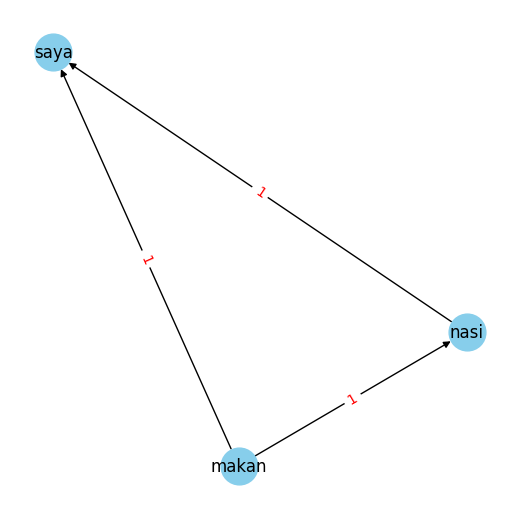

In [92]:
plot_graph(G, figsize=(5, 5), node_size=700,)

## Keywoards Yang di hasilkan

In [91]:
keywords

['saya', 'nasi', 'makan']